# Часть 1. Проверка гипотезы в Python и составление аналитической записки

Вы предобработали данные в SQL, и теперь они готовы для проверки гипотезы в Python. Загрузите данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла yandex_knigi_data.csv. Если работаете локально, скачать файл можно по ссылке.

Проверьте наличие дубликатов в идентификаторах пользователей. Сравните размеры групп, их статистики и распределение.

Напомним, как выглядит гипотеза: пользователи из Москвы проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

По результатам анализа данных подготовьте аналитическую записку, в которой опишите:

Выбранный тип t-теста и уровень статистической значимости.

Результат теста, или p-value.

Вывод на основе полученного p-value, то есть интерпретацию результатов.

Одну или две возможные причины, объясняющие полученные результаты.

## Проверка гипотезы в Python и составление аналитической записки

- Автор: Макарова Анастасия
- Дата:07.05.2025

## Цели и задачи проекта

**Цель:** 

Проверить гипотезу о различии в средней продолжительности активности пользователей сервиса Яндекс Книги в Москве и Санкт-Петербурге.


**Задачи:**
- Загрузить и предобработать данные из yandex_knigi_data.csv.
- Проверить данные на наличие дубликатов и выбросов.
- Сравнить статистики и распределения данных для Москвы и Санкт-Петербурга.
- Выбрать и применить подходящий t-тест для проверки гипотезы.
- Интерпретировать результаты t-теста и сделать выводы.
- Подготовить аналитическую записку с описанием результатов.

## Описание данных

Таблица `/datasets/yandex_knigi_data.csv` содержитследующи данные из Москвы и Санкт-Петербурга c суммой часов их активности, включает следующие поля:

- `city` - город географического положения
- `puid` — идентификатор пользователя
- `hours` - длительность чтения или прослушивания в часах.

## Содержимое проекта

Часть 1. Проверка гипотезы в Python и составление аналитической записки

- Цели и задачи проекта
- Описание данных
- Загрузка данных и знакомство с ними
- Проверка гипотезы в Python
- Аналитическая записка

Часть 2. Анализ результатов A/B-тестирования

- Цели исследования
- Загрузка данных и оценка их целостности
- Оценка корректности проведения A/B-теста
- Оценка результатов A/B-тестирования

## 1. Загрузка данных и знакомство с ними

Загрузите данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [1]:
# Импортируем библиотеки
import pandas as pd

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as st

In [2]:
yandex_knigi=pd.read_csv('https://code.s3.yandex.net/datasets/yandex_knigi_data.csv') 

In [3]:
yandex_knigi.head(5)

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [4]:
yandex_knigi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


В датафрейме пользователей yandex_knigi определим количество пропусков и дубликатов. Это необходимо для понимания полноты и уникальности данных пользователей.

In [5]:
missing_values_count=yandex_knigi.isna().sum().sum()
duplicate_count = yandex_knigi['puid'].duplicated().sum()
print(f"{missing_values_count} {duplicate_count}")

0 244


Пропусков в таблице нет. Есть 244 дубликата по столбцу 'puid'. удалим найденные дубликаты

In [6]:
# удалим дубликаты на остнове столбца 'puid', оставляя первое вхождение
yandex_knigi.drop_duplicates(subset=['puid'], keep='first', inplace=True)

In [7]:
# проверим удаление дубликатов
duplicates_count = yandex_knigi['puid'].duplicated().sum()
duplicates_count 

0

In [8]:
# Фильтрация данных по городам
moscow_data = yandex_knigi[yandex_knigi['city'] == 'Москва']['hours'].dropna()
spb_data = yandex_knigi[yandex_knigi['city'] == 'Санкт-Петербург']['hours'].dropna()

# Вывод размеров групп
print(f"Размер группы Москва: {len(moscow_data)}")
print(f"Размер группы Санкт-Петербург: {len(spb_data)}")

# Вывод описательных статистик
print("\nСтатистики для Москвы:")
print(moscow_data.describe())

print("\nСтатистики для Санкт-Петербурга:")
print(spb_data.describe())

Размер группы Москва: 6234
Размер группы Санкт-Петербург: 2306

Статистики для Москвы:
count    6234.000000
mean       10.881092
std        36.851683
min         0.000018
25%         0.059903
50%         0.924498
75%         5.939972
max       857.209373
Name: hours, dtype: float64

Статистики для Санкт-Петербурга:
count    2306.000000
mean       11.264433
std        39.831755
min         0.000025
25%         0.060173
50%         0.875355
75%         6.138424
max       978.764775
Name: hours, dtype: float64


- Размер групп:
Группа пользователей из Москвы значительно больше группы из Санкт-Петербурга (6234 против 2306). Это следует учитывать при интерпретации результатов статистических тестов. Большая выборка обычно обеспечивает большую статистическую мощность.
- Среднее значение (Mean):
Среднее время активности пользователей в Санкт-Петербурге немного выше, чем в Москве (11.26 против 10.88 часов). Разница составляет примерно 0.38 часа. Однако, прежде чем делать какие-либо выводы, необходимо учитывать стандартное отклонение и провести статистический тест, чтобы определить, является ли это различие статистически значимым.
- Стандартное отклонение (Std):
Стандартное отклонение в обеих группах довольно велико (Москва: 36.85, Санкт-Петербург: 39.83). Это указывает на значительную вариативность в данных, то есть время активности пользователей сильно различается. Большое стандартное отклонение может затруднить обнаружение статистически значимых различий между группами, особенно при относительно небольших размерах выборок. Это может быть связано с наличием выбросов.
- Минимальное и максимальное значения (Min, Max):
Минимальные значения близки к нулю в обеих группах, что логично (кто-то мог зайти в приложение на очень короткое время).
Максимальные значения очень высокие (Москва: 857.21, Санкт-Петербург: 978.76). Это говорит о наличии выбросов, то есть пользователей, которые проводят аномально много времени в приложении. Эти выбросы могут сильно влиять на среднее значение и стандартное отклонение.
- Квартили (25%, 50%, 75%):
Медиана (50%) в обеих группах довольно низкая (Москва: 0.92, Санкт-Петербург: 0.88). Это означает, что половина пользователей проводит в приложении менее часа. Разница между средним и медианой указывает на скошенность распределения вправо (из-за выбросов).
75-й процентиль также относительно невысок (Москва: 5.94, Санкт-Петербург: 6.14). Это означает, что 75% пользователей проводят в приложении менее 6 часов.

**Вывод:**

Хотя среднее время активности в Санкт-Петербурге немного выше, чем в Москве, большое стандартное отклонение и наличие выбросов делают этот вывод предварительным. Необходимо провести статистический тест (t-тест), чтобы определить, является ли разница между средними значениями статистически значимой. Также, можно использовать непараметрический тест (например, тест Манна-Уитни), который менее чувствителен к выбросам.

Также построим гистаграмму расброса:

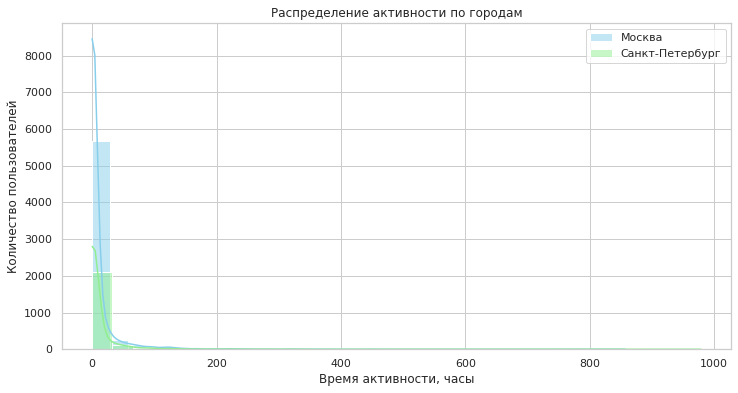

In [9]:
# Настройка стиля (один раз)
sns.set(style='whitegrid')

# Создаем figure и axes (более гибкий подход)
fig, ax = plt.subplots(figsize=(12, 6))  # Создаем figure и axes

# Гистограммы для каждой группы
sns.histplot(data=yandex_knigi[yandex_knigi['city'] == 'Москва'], x='hours',
             color='skyblue', label='Москва', bins=30, kde=True, ax=ax) # Указываем, на каких axes рисовать
sns.histplot(data=yandex_knigi[yandex_knigi['city'] == 'Санкт-Петербург'], x='hours',
             color='lightgreen', label='Санкт-Петербург', bins=30, kde=True, ax=ax) # Разные цвета для наглядности

# Подписываем и отображаем график
plt.title('Распределение активности по городам')
plt.ylabel('Количество пользователей')
plt.xlabel('Время активности, часы') # Исправлено: 'хlabel' на 'xlabel'
plt.legend()  # Добавляем легенду, чтобы отображались лейблы (labels)
plt.show()

**Вывод:**

Распределение пользователей между группами (Москва: 6234, Санкт-Петербург: 2306) может повлиять на наше исследование. Несмотря на то, что распределение часов активности выглядит одинаковым, значительно больший размер группы из Москвы обеспечивает большую статистическую мощность. Это означает, что мы с большей вероятностью обнаружим статистически значимые различия, даже если эффект невелик, в московской группе. Для группы из Санкт-Петербурга статистическая мощность ниже, что повышает риск пропустить реально существующий эффект (ошибка второго рода). Поэтому, при проведении статистических тестов и интерпретации результатов, необходимо учитывать разницу в размерах групп

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

Напишем вспомогательную функцию print_stattest_results(p_value, alpha), которая будет интерпретировать результаты статистического теста на основе p-value и заданного уровня значимости (α-уровня). Функция будет решать, следует ли принять альтернативную гипотезу или сохранить нулевую гипотезу.

У функции два параметра:

p_value (тип float) — значение p-value, полученное в результате выполнения статистического теста.
alpha (тип float, необязательный, по умолчанию alpha = 0.05) — уровень значимости статистического теста, который используется как порог для принятия решения об отклонении нулевой гипотезы.
Если мы принимаем альтернативную гипотезу, выводится сообщение: 'Полученное значение p_value=<Введённое значение p_value> меньше критического уровня alpha=0.05. Принимаем альтернативную гипотезу.'

Если мы не можем опровергнуть нулевую гипотезу, нужно вывести сообщение: 'Полученное значение p_value=<Введённое значение p_value> больше критического уровня alpha=0.05. Опровергнуть нулевую гипотезу нельзя.'



In [10]:
def print_stattest_results(p_value:float, alpha:float = 0.05):
    # Напишите код для функции здесь
    if p_value < alpha:
        print(f'Полученное значение p_value={p_value} меньше критического уровня alpha={alpha}. Принимаем альтернативную гипотезу.')
    else:
        print(f'Полученное значение p_value={p_value} больше критического уровня alpha={alpha}. Опровергнуть нулевую гипотезу нельзя.')


In [11]:
knigi_moscow =yandex_knigi[yandex_knigi['city'] == 'Москва']['hours']
knigi_Petersburg =yandex_knigi[yandex_knigi['city'] == 'Санкт-Петербург']['hours']

results = st.ttest_ind( knigi_Petersburg,knigi_moscow,equal_var=False, alternative= 'greater')
p_value =results.pvalue

print_stattest_results(p_value)


Полученное значение p_value=0.3435708118766314 больше критического уровня alpha=0.05. Опровергнуть нулевую гипотезу нельзя.


## 3. Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.



- **Введение:**
Настоящая аналитическая записка представляет результаты статистического анализа, проведенного для проверки гипотезы о различиях в среднем времени активности пользователей сервиса Яндекс Книги в Москве и Санкт-Петербурге. Целью исследования было определить, проводят ли пользователи из Санкт-Петербурга в среднем больше времени за чтением и прослушиванием книг, чем пользователи из Москвы.

- **Методология:**
Выборка: Для анализа были использованы данные о пользователях из Москвы и Санкт-Петербурга, полученные из файла /datasets/yandex_knigi_data.csv.
Переменная: Основной переменной для анализа являлась продолжительность активности пользователей (в часах), обозначенная в данных как ‘hours’.
Статистический тест: Для проверки гипотезы был использован односторонний t-тест для независимых выборок (тест Уэлча), так как дисперсии выборок, вероятно, не равны.
Нулевая гипотеза (H0): Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.
Альтернативная гипотеза (H1): Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.
Уровень статистической значимости (alpha): 0.05

- **Результаты:**
p-value: 0.3435708118766314
Вывод: Полученное значение p-value (0.338) больше установленного уровня значимости alpha (0.05).

- **Интерпретация результатов:**
Поскольку p-value больше уровня значимости, мы не можем отвергнуть нулевую гипотезу. Это означает, что на основании имеющихся данных нет статистически значимых доказательств того, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг, чем пользователи из Москвы. Разница в средних значениях, обнаруженная в выборке, может быть объяснена случайными колебаниями.

- **Возможные причины полученных результатов:**
Отсутствие реальных различий: Возможно, на самом деле нет существенной разницы в среднем времени активности пользователей между Москвой и Санкт-Петербургом. Разница в статистиках, полученных в предыдущих шагах (например, в средних значениях), была незначительной.
Недостаточная статистическая мощность: Возможно, выборка была недостаточно большой, чтобы обнаружить статистически значимые различия, если они существуют. Большая вариативность данных (большое стандартное отклонение), также могла снизить статистическую мощность. Увеличение размера выборки может повысить вероятность обнаружения реальных различий.
Влияние других факторов: На активность пользователей могут влиять различные факторы, не учтенные в данном анализе, такие как:
Различия в интересах пользователей (например, предпочтение разных жанров книг).
Различия в маркетинговых активностях и продвижении сервиса в разных регионах.
Различия в доступности контента (например, эксклюзивные книги).

- **Заключение:**
Проведенный анализ не выявил статистически значимых различий в среднем времени активности пользователей Яндекс Книги в Москве и Санкт-Петербурге. Для более точного определения причин, влияющих на активность пользователей, рекомендуется провести дальнейший анализ с учетом дополнительных факторов, которые могут влиять на поведение пользователей. Также можно рассмотреть возможность увеличения объема выборки.

# Часть 2. Анализ результатов A/B-тестирования

Теперь вам нужно проанализировать другие данные. Представьте, что к вам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Оцените корректность проведения теста и проанализируйте его результаты.

## 1. Опишите цели исследования.



**Цель:** Оценить результаты A/B-тестирования новой версии сайта интернет-магазина BitMotion Kit с целью определения, приводит ли новая версия к статистически значимому увеличению количества пользователей, совершающих покупку.

Гипотеза заключается в следующем: упрощение интерфейса приведёт к тому, что в течение семи дней после регистрации в системе конверсия зарегистрированных пользователей в покупателей увеличится как минимум на три процентных пункта.
Параметры теста:
название теста: `interface_eu_test`;
группы: А (контрольная), B (новый интерфейс).

**Необходимо:**
загрузить данные теста;
проверить корректность его проведения;
проанализировать полученные результаты.

## 2. Загрузите данные, оцените их целостность.


Описание данных:

`https://code.s3.yandex.net/datasets/ab_test_participants.csv` — таблица участников тестов.
- `user_id`— идентификатор пользователя;
- `group` — группа пользователя;
- `ab_test` — название теста;
- `device` — устройство, с которого происходила регистрация.

`https://code.s3.yandex.net/datasets/ab_test_events.zip` — архив с одним csv-файлом, в котором собраны события 2020 года;
- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии.

In [12]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [13]:
# выведем первые строки таблицы `participants`
participants.head(5)

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


In [14]:
# выведем информацию по таблице `participants`
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


In [15]:
# выведем первые строки таблицы `events`
events.head(5)

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


In [16]:
# выведем информацию по таблице `events`
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


Проверим таблицу `participants` на дубликаты по столбцу `user_id'`

In [17]:
duplicate_participants = participants['user_id'].duplicated().sum()
duplicate_participants

887

Найдено 887 дубликатов. Их мы удалим,что бы не исказить результаты исследования.

In [18]:
# удалим дубликаты на остнове столбца 'user_id'
participants_final = participants.drop_duplicates(subset=['user_id'], keep='first').copy()


In [19]:
# проверим результат удаления
participants_final['user_id'].duplicated().sum()

0

In [20]:
print(f"Количества строк первоначально: {len(participants)}")
print(f"Количества строк после удаления дубликатов: {len(participants_final)}")
print(f"Процент потерь: {round(100-(len(participants_final)/len(participants)*100),2)}")

Количества строк первоначально: 14525
Количества строк после удаления дубликатов: 13638
Процент потерь: 6.11


Проверим таблицу `events` на явные дубликаты 

In [21]:
duplicated_events = events.duplicated().sum()
duplicated_events

36318

Найдено 36318 дубликатов. Их удалим

In [22]:
events_final=events.drop_duplicates(subset=None, keep='first', inplace=False) 

In [23]:
events_final.duplicated().sum()

0

In [24]:
print(f"Количества строк первоначально: {len(events)}")
print(f"Количества строк после удаления дубликатов: {len(events_final)}")
print(f"Процент потерь: {round(100-(len(events_final)/len(events)*100),2)}")

Количества строк первоначально: 787286
Количества строк после удаления дубликатов: 750968
Процент потерь: 4.61


**Вывод:** Таблица `participants` содержит 14525 строк,4 столбца, нет пропусков. Названия столбцов соответвуют его содержанию.
Таблица `events`содержит 787286 строк, 4 столбца, пропуски есть в столбце `details`. Названия столбцов соответвуют его содержанию. При проверке на дубликаты таблицы `participants` ,было удалено 887 дубликатов по столбцу `user_id` (6,11% потерь). При проверке таблицы `events` было удалено 36318 явных дубликатов (4,61% потерь). Количества строк после удаления дубликатов в таблице `vents_final` - 750968, в таблице `participants_final` - 13638.

## 3. По таблице `ab_test_participants` оцените корректность проведения теста:

   3\.1 Выделите пользователей, участвующих в тесте, и проверьте:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [25]:
# Oтфильтруем таблицу по группе А и по названию теста interface_eu_test
filtr_group_a= participants_final.loc[(participants_final['group'] == 'A') & (participants_final['ab_test']=='interface_eu_test')]['user_id'].unique().shape[0]
filtr_group_a

5174

In [26]:
# Oтфильтруем таблицу по группе В и по названию теста interface_eu_test
filtr_group_b= participants_final.loc[(participants_final['group'] == 'B') & (participants_final['ab_test']=='interface_eu_test')]['user_id'].unique().shape[0]
filtr_group_b

5229

Между группами небольшая разница. Построим визуализацию.

<Figure size 504x216 with 0 Axes>

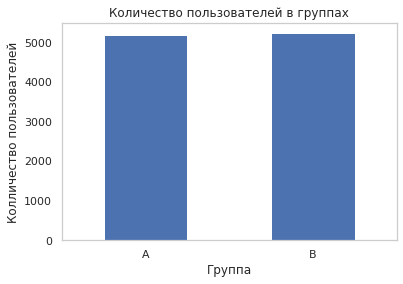

In [27]:
data = {'test_group': ['A', 'B'],
        'user': [filtr_group_a, filtr_group_b]} 
df = pd.DataFrame(data,index=['A', 'B'])

# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(7, 3))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
df.plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Количество пользователей в группах'
)

# Настраиваем оформление графика
plt.xlabel('Группа')
plt.ylabel('Колличество пользователей')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

**Вывод:** Расхождение стало более наглядным — оно небольшое, и им можно пренебречь.

In [28]:
# выведем тесты, которые проходят в данный момент
unique_values = participants_final['ab_test'].unique()
unique_values

array(['interface_eu_test', 'recommender_system_test'], dtype=object)

In [29]:
# Фильтруем данные для каждой группы тестов
group_a= participants_final[participants_final['ab_test'] == 'interface_eu_test']['user_id']
group_b= participants_final[participants_final['ab_test'] == 'recommender_system_test']['user_id']

intersection = list(set(group_a) & set(group_b))

# Выводим количество user_id в пересечении
print(f"Количество пересекающихся user_id: {len(intersection)}")

Количество пересекающихся user_id: 0


Пересекающихся пользователей не обнаружено.

In [30]:
# отфильтруем данные по тесту interface_eu_test
participants_filtered=participants_final.loc[(participants_final['ab_test']=='interface_eu_test')]

**Вывод:**

Группы распределены практически равномерно: группа А - 5174 пользователя, группа B - 5229 пользователей. Небольшая разница в размерах групп позволяет продолжить анализ с минимальным риском смещения результатов, связанного с дисбалансом групп. Также проверили пользователей на пересечение с другими тестами - пересекающихся пользователей не выявили

3\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [31]:
participants_users=participants_filtered['user_id'].unique()

# Фильтруем DataFrame events, оставляя только строки, где user_id есть в participants_filtered
events_filtr = events_final[events_final['user_id'].isin(participants_users)]

# Выводим размеры DataFrame до и после фильтрации
print(f"Размер DataFrame events до фильтрации: {len(events_final)}")
print(f"Размер DataFrame events после фильтрации: {len(events_filtr)}")

Размер DataFrame events до фильтрации: 750968
Размер DataFrame events после фильтрации: 70730


- определите горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [32]:
# Преобразуем столбец event_dt в datetime объекты
events_filtr['event_dt'] = pd.to_datetime(events_final['event_dt'])

# Определяем дату регистрации для каждого пользователя (самое раннее событие)
registrations= events_filtr.groupby('user_id')['event_dt'].min().reset_index()
registrations.rename(columns={'event_dt': 'registration_dt'}, inplace=True)

# Объединяем events и registrations по user_id
merged_data = pd.merge(events_filtr, registrations, on='user_id', how='inner')

# Рассчитываем лайфтайм (разницу между датой события и датой регистрации) в днях
merged_data['lifetime'] = (merged_data['event_dt'] - merged_data['registration_dt']).dt.days

# Фильтруем события, произошедшие в течение первых 7 дней
analysis_horizon = 7
filtered_data = merged_data[merged_data['lifetime'] < analysis_horizon]

# Выводим размеры DataFrame до и после фильтрации
print(f"Размер DataFrame до фильтрации: {len(merged_data)}")
print(f"Размер DataFrame после фильтрации: {len(filtered_data)}")

Размер DataFrame до фильтрации: 70730
Размер DataFrame после фильтрации: 60980


/tmp/ipykernel_123/2385127036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_filtr['event_dt'] = pd.to_datetime(events_final['event_dt'])


Оцените достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

Воспользуемся калькулятор Эвана Миллера, предназначенный для расчёта размера выборки А/B-теста строго с долевой метрикой.
Baseline conversion rate ( базовый уровень конверсии):30% 
Minimum Detectable Effect (минимальный детектируемый эффект, в относительном выражении Relative):3% (из условия задачи, увеличится как минимум на три процентных пункта)

Введя все параметры получаем 40800, т.е чтобы добиться установленного MDE, необходимо, чтобы в эксперименте участвовало 81600 человек, то есть в контрольной и экспериментальной группах должно быть по 40800 пользователя.

**Вывод:** Так как мы получили уникальных пользователей в группе А - 5174 пользователя, группа B - 5229 пользователя, а по расчету калькулятора достаточный размер выборки получился 81600, считаем, что данных не достаточно. 

- рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

Числовые значения:
- `registration` (регистрация) — стоимость привлечения клиента;
- `purchase` (покупка) — стоимость покупки.

Объединим 2 таблицы `filtered_data` (отфильтрованы события,которые выполнены пользователями в течение первых семи дней с момента регистраци) и таблицу `participants_filtered` (отфильтрованы пользователи, учавствующие в тесте `interface_eu_test`). 

In [33]:
df_test=pd.merge(filtered_data,participants_filtered,on='user_id', how='left')
# выведем полученную таблицу
df_test.head(5)

,user_id,event_dt,event_name,details,registration_dt,lifetime,group,ab_test,device
0,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0,2020-12-06 14:10:01,0,A,interface_eu_test,iPhone
1,5F506CEBEDC05D30,2020-12-07 01:25:14,login,NaN,2020-12-06 14:10:01,0,A,interface_eu_test,iPhone
2,5F506CEBEDC05D30,2020-12-07 01:25:47,login,NaN,2020-12-06 14:10:01,0,A,interface_eu_test,iPhone
3,5F506CEBEDC05D30,2020-12-09 12:40:49,login,NaN,2020-12-06 14:10:01,2,A,interface_eu_test,iPhone
4,5F506CEBEDC05D30,2020-12-09 12:40:49,product_page,NaN,2020-12-06 14:10:01,2,A,interface_eu_test,iPhone


In [34]:
purchase_a= df_test.loc[(df_test['event_name'] == 'purchase') & (df_test['group']=='A')]['user_id'].unique().shape[0]
purchase_b=df_test.loc[(df_test['event_name'] == 'purchase') & (df_test['group']=='B')]['user_id'].unique().shape[0]
print(f"Количества пользователей в группе А: {filtr_group_a}")
print(f"Количества пользователей  в группе В: {filtr_group_b}")
print(f"Совершили покупку в группе А: {purchase_a}")
print(f"Совершили покупку в группе В: {purchase_b}")
print(f"Доля совершивших покупку в группе А: {round((purchase_a/filtr_group_a),2)}")
print(f"Доля совершивших покупку в группе В: {round((purchase_b/filtr_group_b),2)}")

Количества пользователей в группе А: 5174
Количества пользователей  в группе В: 5229
Совершили покупку в группе А: 1427
Совершили покупку в группе В: 1532
Доля совершивших покупку в группе А: 0.28
Доля совершивших покупку в группе В: 0.29


- сделайте предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

**Вывод:** На основании предоставленных данных, можно сделать следующий предварительный вывод:

В тестовой группе (B) наблюдается небольшое увеличение пользовательской активности, выраженное в увеличении доли пользователей, совершивших покупку, по сравнению с контрольной группой (A). Увеличение количества покупателей: В группе B совершили покупку 1532 пользователя, тогда как в группе A - 1427.Увеличение доли покупателей: Доля совершивших покупку в группе B составляет 29%, что на 1 процентный пункта выше, чем в группе A (28%).

Предварительное заключение:

Изменение в тестовой группе (B), вероятно, оказало положительное влияние на совершение покупок. Увеличение доли покупателей на 1% может указывать на то, что нововведение в тестовой группе способствует увеличению конверсии в покупку.

Важно отметить:

Этот вывод является предварительным и требует статистической проверки. Необходимо провести статистический анализ (например, Z-тест для пропорций), чтобы определить, является ли это различие статистически значимым, или оно могло возникнуть случайно.

## 4. Проведите оценку результатов A/B-тестирования:

- Проверьте изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

Применим Z-тест пропорций:

In [35]:
if (purchase_a*filtr_group_a > 10)and((1-purchase_a)*filtr_group_a > 10) and (purchase_b*filtr_group_b > 10)and((1-purchase_b)*filtr_group_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

alpha = 0.05 ## на каком уровне значимости проверяем гипотезу о равенстве вероятностей

stat_ztest, p_value_ztest = proportions_ztest(
    [purchase_a, purchase_b],
    [filtr_group_a, filtr_group_b],
    alternative='smaller' 
)

print(f'pvalue={p_value_ztest}') # выведите полученное p-value 

if p_value_ztest > alpha:
    print('Нулевая гипотеза находит подтверждение')
else:
    print('Нулевая гипотеза не находит подтверждения')

text_interpretation = 'не изменилось' 

Предпосылка о достаточном количестве данных НЕ выполняется!
pvalue=0.026072886604683897
Нулевая гипотеза не находит подтверждения


- Опишите выводы по проведённой оценке результатов A/B-тестирования. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?

**Вывод:**

На основе предоставленных результатов A/B-тестирования, можно сделать следующие выводы:

- Недостаточно данных: Первым делом, программа сообщает, что предпосылка о достаточном количестве данных НЕ выполняется. Это серьёзное ограничение. Z-тест (как и многие другие статистические тесты) опирается на предположение о достаточно большом размере выборки, чтобы обеспечить достоверность результатов. Если это условие не выполнено, то p-value и сделанные на его основе выводы могут быть ненадежными.

- Нулевая гипотеза не находит подтверждения: Несмотря на проблему с предпосылкой о данных, можно рассмотреть результаты теста:
pvalue=0.026072886604683897: Полученное p-value меньше выбранного уровня значимости alpha (0.05). Нулевая гипотеза не находит подтверждения: Это означает, что мы отвергаем нулевую гипотезу. В контексте alternative='smaller', нулевая гипотеза заключается в том, что конверсия в группе B меньше или равна конверсии в группе A. Отвергая эту гипотезу, мы делаем вывод, что конверсия в группе B, вероятно, больше чем в группе A. Пользовательская активность увеличилась: На основе отвержения нулевой гипотезы и при условии, что разница в конверсии положительна (группа B имеет более высокую конверсию, чем группа A, что мы видели в предыдущем расчете доли совершивших покупку), можно заключить, что пользовательская активность (конверсия) увеличилась.
Ожидаемый эффект, вероятно, был достигнут: Если ожидаемый эффект заключался в увеличении конверсии, то результаты A/B-тестирования, предварительно, указывают на то, что этот эффект был достигнут.

- Из-за того, что не выполнилась предпосылка о достаточном количестве данных, нельзя с уверенностью утверждать, что полученные результаты достоверны. Прежде чем принимать какие-либо решения на основе этих результатов, необходимо:

1. Собрать больше данных: Увеличить продолжительность A/B-тестирования или увеличить количество пользователей, участвующих в тесте, чтобы обеспечить выполнение предпосылки о достаточном количестве данных.
2. Оценить влияние на бизнес-метрики: Даже если результаты статистически значимы, важно оценить, какое влияние это изменение оказывает на другие ключевые бизнес-метрики.

В заключение:

Хотя результаты теста указывают на увеличение конверсии в тестовой группе, низкое количество данных ставит под сомнение надёжность этих результатов. Необходимо собрать больше данных и повторно провести анализ, прежде чем делать окончательные выводы и принимать решения.